Librerias

In [157]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import point, polygon
import rasterio
import rasterstats
import pandas as pd
from rasterstats import zonal_stats
import unicodedata
from pathlib import Path
from matplotlib.patches import Rectangle
import os
from scipy.stats import pearsonr, spearmanr
import seaborn as sns


Carga de datos



Limites administrativos


In [105]:
path = "../Data/Raw/comunas.shp"
gdf_regional = gpd.read_file(path)


Aeropuertos

In [106]:
path1 = "../Data/Raw/Aeropuertos.shp"
gdf_aeropuertos = gpd.read_file(path1)


Raster


In [107]:

ruta_raster = ("../Data/Raw/VNL_npp_2024_global_vcmslcfg_v2_c202502261200.average_masked.dat.tif")

Datos Censo

In [108]:
ruta1 = "../Data/Raw/D1_Poblacion-censada-por-sexo-y-edad-en-grupos-quinquenales.xlsx"
df_poblacion = pd.read_excel(ruta1, sheet_name = "2", skiprows=3)

In [109]:
df_poblacion.head(2)

,Código región,Región,Código provincia,Provincia,Código comuna,Comuna,Población censada,Hombres,Mujeres,Razón hombre-mujer
0,0,País,0.0,País,0.0,País,18480432.0,8967033.0,9513399.0,94.3
1,15,Arica y Parinacota,151.0,Arica,15101.0,Arica,241653.0,118844.0,122809.0,96.8


#### Procesamiento de datos

Armonizacion de CRS

In [110]:
gdf_regional = gdf_regional.to_crs("EPSG:4326")

In [111]:
gdf_aeropuertos = gdf_aeropuertos.to_crs("EPSG:4326")

Procesamiento de aeropuertos

In [112]:
gdf_aeropuertos = gdf_aeropuertos[gdf_aeropuertos['categoría'] != 'Aeródromo']

Procesamiento de las columnas de region 

In [113]:
gdf_regional.head(2)

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-71.80071 -34.20728, -71.79992 -34.2..."
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-70.35293 -33.95263, -70.35243 -33.9..."


In [114]:
gdf_regional.Region.unique()

array(["Región del Libertador Bernardo O'Higgins",
       'Región de La Araucanía', 'Región Metropolitana de Santiago',
       'Región de Los Lagos', 'Región de Los Ríos', 'Región del Maule',
       'Región de Coquimbo', 'Región de Magallanes y Antártica Chilena',
       'Zona sin demarcar', 'Región de Valparaíso', 'Región del Bío-Bío',
       'Región de Aysén del Gral.Ibañez del Campo', 'Región de Tarapacá',
       'Región de Arica y Parinacota', 'Región de Antofagasta',
       'Región de Ñuble', 'Región de Atacama'], dtype=object)

In [115]:
df_poblacion.head(2)

,Código región,Región,Código provincia,Provincia,Código comuna,Comuna,Población censada,Hombres,Mujeres,Razón hombre-mujer
0,0,País,0.0,País,0.0,País,18480432.0,8967033.0,9513399.0,94.3
1,15,Arica y Parinacota,151.0,Arica,15101.0,Arica,241653.0,118844.0,122809.0,96.8


In [116]:
df_poblacion.Región.unique()

array(['País', 'Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama',
       'Coquimbo', 'Valparaíso', 'Metropolitana de Santiago',
       "Libertador General Bernardo O'Higgins", 'Maule', 'Ñuble',
       'Biobío', 'La Araucanía', 'Los Ríos', 'Los Lagos',
       'Aysén del General Carlos Ibáñez del Campo',
       'Magallanes y de la Antártica Chilena', nan], dtype=object)

In [117]:
diccionario_regiones = {
    "Arica y Parinacota": "Región de Arica y Parinacota",
    "Tarapacá": "Región de Tarapacá",
    "Antofagasta": "Región de Antofagasta",
    "Atacama": "Región de Atacama",
    "Coquimbo": "Región de Coquimbo",
    "Valparaíso": "Región de Valparaíso",
    "Metropolitana de Santiago": "Región Metropolitana de Santiago",
    "Libertador General Bernardo O'Higgins": "Región del Libertador Bernardo O'Higgins",
    "Maule": "Región del Maule",
    "Ñuble": "Región de Ñuble",
    "Biobío": "Región del Bío-Bío",
    "La Araucanía": "Región de La Araucanía",
    "Los Ríos": "Región de Los Ríos",
    "Los Lagos": "Región de Los Lagos",
    "Aysén del General Carlos Ibáñez del Campo": "Región de Aysén del Gral.Ibañez del Campo",
    "Magallanes y de la Antártica Chilena": "Región de Magallanes y Antártica Chilena",
    "País": "Zona sin demarcar",
    np.nan: "Zona sin demarcar"    
}


In [118]:
df_poblacion = df_poblacion.replace({"Región":diccionario_regiones})

In [119]:
df_poblacion

,Código región,Región,Código provincia,Provincia,Código comuna,Comuna,Población censada,Hombres,Mujeres,Razón hombre-mujer
0,0,Zona sin demarcar,0.0,País,0.0,País,18480432.0,8967033.0,9513399.0,94.3
1,15,Región de Arica y Parinacota,151.0,Arica,15101.0,Arica,241653.0,118844.0,122809.0,96.8
2,15,Región de Arica y Parinacota,151.0,Arica,15102.0,Camarones,861.0,430.0,431.0,99.8
3,15,Región de Arica y Parinacota,152.0,Parinacota,15201.0,Putre,1547.0,846.0,701.0,120.7
4,15,Región de Arica y Parinacota,152.0,Parinacota,15202.0,General Lagos,508.0,261.0,247.0,105.7
...,...,...,...,...,...,...,...,...,...,...
344,12,Región de Magallanes y Antártica Chilena,123.0,Tierra del Fuego,12303.0,Timaukel,157.0,95.0,62.0,153.2
345,12,Región de Magallanes y Antártica Chilena,124.0,Última Esperanza,12401.0,Natales,24152.0,12064.0,12088.0,99.8
346,12,Región de Magallanes y Antártica Chilena,124.0,Última Esperanza,12402.0,Torres del Paine,203.0,118.0,85.0,138.8
347,NaN,Zona sin demarcar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
gdf_regional = gdf_regional[gdf_regional['Region'] != 'Zona sin demarcar']

In [121]:
df_poblacion = df_poblacion[df_poblacion['Región'] != 'Zona sin demarcar']

In [122]:
df_poblacion.Región.unique()

array(['Región de Arica y Parinacota', 'Región de Tarapacá',
       'Región de Antofagasta', 'Región de Atacama', 'Región de Coquimbo',
       'Región de Valparaíso', 'Región Metropolitana de Santiago',
       "Región del Libertador Bernardo O'Higgins", 'Región del Maule',
       'Región de Ñuble', 'Región del Bío-Bío', 'Región de La Araucanía',
       'Región de Los Ríos', 'Región de Los Lagos',
       'Región de Aysén del Gral.Ibañez del Campo',
       'Región de Magallanes y Antártica Chilena'], dtype=object)

In [123]:
gdf_regional.Region.unique()

array(["Región del Libertador Bernardo O'Higgins",
       'Región de La Araucanía', 'Región Metropolitana de Santiago',
       'Región de Los Lagos', 'Región de Los Ríos', 'Región del Maule',
       'Región de Coquimbo', 'Región de Magallanes y Antártica Chilena',
       'Región de Valparaíso', 'Región del Bío-Bío',
       'Región de Aysén del Gral.Ibañez del Campo', 'Región de Tarapacá',
       'Región de Arica y Parinacota', 'Región de Antofagasta',
       'Región de Ñuble', 'Región de Atacama'], dtype=object)

Filtrar columnas relevantes

In [124]:
gdf_regional =gdf_regional[['Region','Comuna','geometry']]
df_poblacion =df_poblacion[['Región','Comuna','Población censada']]

In [125]:
gdf_regional.head(2)

,Region,Comuna,geometry
0,Región del Libertador Bernardo O'Higgins,Marchigüe,"POLYGON ((-71.80071 -34.20728, -71.79992 -34.2..."
1,Región del Libertador Bernardo O'Higgins,Codegua,"POLYGON ((-70.35293 -33.95263, -70.35243 -33.9..."


In [126]:
df_poblacion.head(2)

,Región,Comuna,Población censada
1,Región de Arica y Parinacota,Arica,241653.0
2,Región de Arica y Parinacota,Camarones,861.0


Procesamiento de comuna

In [127]:
gdf_regional.shape

(345, 3)

In [128]:
df_poblacion.shape

(346, 3)

Comparacion de Arrays numpy

In [129]:
arr1 = np.setdiff1d(gdf_regional.Comuna.unique(), df_poblacion.Comuna.unique())
arr2 = np.setdiff1d(df_poblacion.Comuna.unique(), gdf_regional.Comuna.unique())

In [130]:
arr1

array(['Los Alamos', 'Los Angeles', 'Marchigüe', 'Paihuano', 'Ranquil',
       'San Pedro de la Paz', 'Treguaco'], dtype=object)

In [131]:
arr2

array(['Antártica', 'Los Álamos', 'Los Ángeles', 'Marchihue', 'Paiguano',
       'Ránquil', 'San Pedro de La paz', 'Trehuaco'], dtype=object)

Eliminamos la Antartica

In [132]:
df_poblacion =  df_poblacion[df_poblacion['Comuna'] != 'Antártica']

Solucionar los nombres de las comunas

In [133]:
diccionario_comunas = {
    'Los Álamos': 'Los Alamos',
    'Los Ángeles': 'Los Angeles',
    'Marchihue': 'Marchigüe',
    'Paiguano': 'Paihuano',
    'Ránquil': 'Ranquil',
    'San Pedro de La paz': 'San Pedro de la Paz',
    'Trehuaco': 'Treguaco'
}

In [134]:
df_poblacion = df_poblacion.replace({"Comuna": diccionario_comunas})

In [135]:
df_poblacion

,Región,Comuna,Población censada
1,Región de Arica y Parinacota,Arica,241653.0
2,Región de Arica y Parinacota,Camarones,861.0
3,Región de Arica y Parinacota,Putre,1547.0
4,Región de Arica y Parinacota,General Lagos,508.0
5,Región de Tarapacá,Iquique,199587.0
...,...,...,...
342,Región de Magallanes y Antártica Chilena,Porvenir,6809.0
343,Región de Magallanes y Antártica Chilena,Primavera,431.0
344,Región de Magallanes y Antártica Chilena,Timaukel,157.0
345,Región de Magallanes y Antártica Chilena,Natales,24152.0


Geodataframe poblacional a partir de un merge

In [136]:
gdf_poblacion = gdf_regional.merge(df_poblacion, left_on = 'Comuna', right_on= 'Comuna', how= 'left').drop(columns= ['Región'])

In [137]:
gdf_poblacion

,Region,Comuna,geometry,Población censada
0,Región del Libertador Bernardo O'Higgins,Marchigüe,"POLYGON ((-71.80071 -34.20728, -71.79992 -34.2...",8715.0
1,Región del Libertador Bernardo O'Higgins,Codegua,"POLYGON ((-70.35293 -33.95263, -70.35243 -33.9...",13955.0
2,Región del Libertador Bernardo O'Higgins,Coinco,"POLYGON ((-70.90058 -34.23703, -70.90063 -34.2...",7916.0
3,Región del Libertador Bernardo O'Higgins,Coltauco,"POLYGON ((-71.02492 -34.17053, -71.0232 -34.17...",21373.0
4,Región de La Araucanía,Cholchol,"POLYGON ((-72.95898 -38.46877, -72.95797 -38.4...",13167.0
...,...,...,...,...
340,Región de Ñuble,San Nicolás,"POLYGON ((-72.24207 -36.35227, -72.24014 -36.3...",15099.0
341,Región de Ñuble,San Fabián,"POLYGON ((-71.24834 -36.45596, -71.24827 -36.4...",5245.0
342,Región de Ñuble,Ñiquén,"POLYGON ((-72.09907 -36.13712, -72.09819 -36.1...",12797.0
343,Región de Ñuble,El Carmen,"POLYGON ((-71.74229 -36.82882, -71.74224 -36.8...",13186.0


Manejo del raster

In [138]:
brillo_promedio = zonal_stats(gdf_poblacion, ruta_raster, stats = ['mean'])

In [139]:
brillo_total = zonal_stats(gdf_poblacion, ruta_raster, stats = ['sum'])

In [140]:
gdf_poblacion['brillo_promedio'] = [stat['mean'] for stat in brillo_promedio]

In [141]:
gdf_poblacion['brillo_total'] = [stat['sum'] for stat in brillo_total]

In [142]:
gdf_poblacion

,Region,Comuna,geometry,Población censada,brillo_promedio,brillo_total
0,Región del Libertador Bernardo O'Higgins,Marchigüe,"POLYGON ((-71.80071 -34.20728, -71.79992 -34.2...",8715.0,0.334509,1242.367920
1,Región del Libertador Bernardo O'Higgins,Codegua,"POLYGON ((-70.35293 -33.95263, -70.35243 -33.9...",13955.0,1.253766,2009.787598
2,Región del Libertador Bernardo O'Higgins,Coinco,"POLYGON ((-70.90058 -34.23703, -70.90063 -34.2...",7916.0,1.886844,1043.424805
3,Región del Libertador Bernardo O'Higgins,Coltauco,"POLYGON ((-71.02492 -34.17053, -71.0232 -34.17...",21373.0,1.158396,1446.837036
4,Región de La Araucanía,Cholchol,"POLYGON ((-72.95898 -38.46877, -72.95797 -38.4...",13167.0,0.102332,259.411346
...,...,...,...,...,...,...
340,Región de Ñuble,San Nicolás,"POLYGON ((-72.24207 -36.35227, -72.24014 -36.3...",15099.0,0.195490,638.079346
341,Región de Ñuble,San Fabián,"POLYGON ((-71.24834 -36.45596, -71.24827 -36.4...",5245.0,0.038722,346.060638
342,Región de Ñuble,Ñiquén,"POLYGON ((-72.09907 -36.13712, -72.09819 -36.1...",12797.0,0.144303,413.716370
343,Región de Ñuble,El Carmen,"POLYGON ((-71.74229 -36.82882, -71.74224 -36.8...",13186.0,0.205455,797.781433


### Mapa coropletico de poblacion 


In [ ]:
def _norm(s):
    if pd.isna(s): return ""
    return unicodedata.normalize("NFKD", str(s)).encode("ascii", "ignore").decode("ascii").lower()

def add_scalebar(ax, length_km=None, loc='lower left', pad=0.02, height=2000, color='k', lw=1.5, text_kw=None):
    if text_kw is None:
        text_kw = dict(ha='center', va='bottom', fontsize=9)
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    width = xmax - xmin; height_ax = ymax - ymin

    # escoger un largo  (en metros)
    if length_km is None:
        target = width/5
        bases = [1,2,5]
        exp = int(f"{target:.1e}".split('e')[-1])
        best = bases[0]*(10**exp)
        for b in bases:
            cand = b*(10**exp)
            if abs(cand-target) < abs(best-target): best = cand
        length_m = best
    else:
        length_m = length_km*1000

    if loc == 'lower right':
        x0 = xmax - pad*width - length_m
    else:
        x0 = xmin + pad*width
    y0 = ymin + pad*height_ax

    ax.add_patch(Rectangle((x0, y0), length_m, height, facecolor='none', edgecolor=color, lw=lw))
    ax.text(x0 + length_m/2, y0 + height*1.2, f"{int(round(length_m/1000))} km", **text_kw)

def add_north_arrow(ax, size=9000, loc='upper left', pad=0.03, color='k'):
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    dx = xmax - xmin; dy = ymax - ymin
    if loc == 'upper right':
        x = xmax - pad*dx; ha = 'right'
    else:
        x = xmin + pad*dx; ha = 'left'
    y = ymax - pad*dy
    ax.annotate('', xy=(x, y), xytext=(x, y - size),
                arrowprops=dict(arrowstyle='-|>', color=color, lw=2, shrinkA=0, shrinkB=0))
    ax.text(x, y - size - size*0.2, 'N', ha=ha, va='top', fontsize=12, color=color)



In [ ]:
def plot_region_choropleth(
    gdf_poblacion: gpd.GeoDataFrame,
    gdf_aeropuertos: gpd.GeoDataFrame,
    region_name: str,
    value_col_candidates = ('Población censada','poblacion_censada','poblacion','Poblacion'),
    out_dir = Path("Reports/figs"),
    out_name_prefix = "poblacion",
    cmap="OrRd"
):
    out_dir.mkdir(parents=True, exist_ok=True)

    # 1) detectar/renombrar columna de población
    col_pob = next((c for c in value_col_candidates if c in gdf_poblacion.columns), None)
    if col_pob is None:
        raise ValueError(f"No encontré columna de población en: {list(gdf_poblacion.columns)}")
    gdf = gdf_poblacion.rename(columns={col_pob: 'poblacion_censada'}).copy()

    if 'Region' not in gdf.columns:
        raise ValueError("No encontré columna 'Region' en gdf_poblacion.")

    # 2) filtrar región 
    mask = gdf['Region'].map(lambda s: _norm(s)).str.contains(_norm(region_name), na=False)
    gdf_reg = gdf[mask].copy()
    if gdf_reg.empty:
        raise ValueError(f"No se encontró la región: {region_name}. Valores ejemplo: {gdf['Region'].unique()[:5]}")

    # 3) CRS → para escala/flecha
    if gdf_reg.crs is None:
        gdf_reg = gdf_reg.set_crs(4326)
    utm = gdf_reg.estimate_utm_crs()
    gdf_reg_utm = gdf_reg.to_crs(utm)

    # aeropuertos reproyectados y recortados a la región
    gdf_aero = gdf_aeropuertos.copy()
    if gdf_aero.crs is None:
        gdf_aero = gdf_aero.set_crs(gdf_reg.crs or 4326)
    gdf_aero_utm = gdf_aero.to_crs(utm)
    if not gdf_aero_utm.empty:
        gdf_aero_utm = gdf_aero_utm[gdf_aero_utm.within(gdf_reg_utm.unary_union)]

    # 4) dibujo
    fig, ax = plt.subplots(figsize=(7.5, 8))
    gdf_reg_utm.plot(
        column='poblacion_censada', ax=ax, cmap=cmap, legend=True,
        edgecolor='0.4', linewidth=0.4,
        legend_kwds=dict(label="Población censada", orientation="vertical")
    )
    if not gdf_aero_utm.empty:
        gdf_aero_utm.plot(ax=ax, color='dodgerblue', markersize=22,
                          edgecolor='white', linewidth=0.5, zorder=3)

    ax.set_title(f"{region_name} – Población por comuna", fontsize=13)
    ax.set_axis_off()
    add_scalebar(ax)       # automático
    add_north_arrow(ax)    # flecha norte

    # 5) exportar
    slug = _norm(region_name).replace(" ", "_")
    out_png = out_dir / f"{out_name_prefix}_{slug}.png"
    plt.tight_layout()
    plt.savefig("../Reports/figs/poblacion_rm.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Mapa exportado en:", out_png.as_posix())    

C:\Users\marcel gonzalez\AppData\Local\Temp\ipykernel_1016\899503269.py:39: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_aero_utm = gdf_aero_utm[gdf_aero_utm.within(gdf_reg_utm.unary_union)]


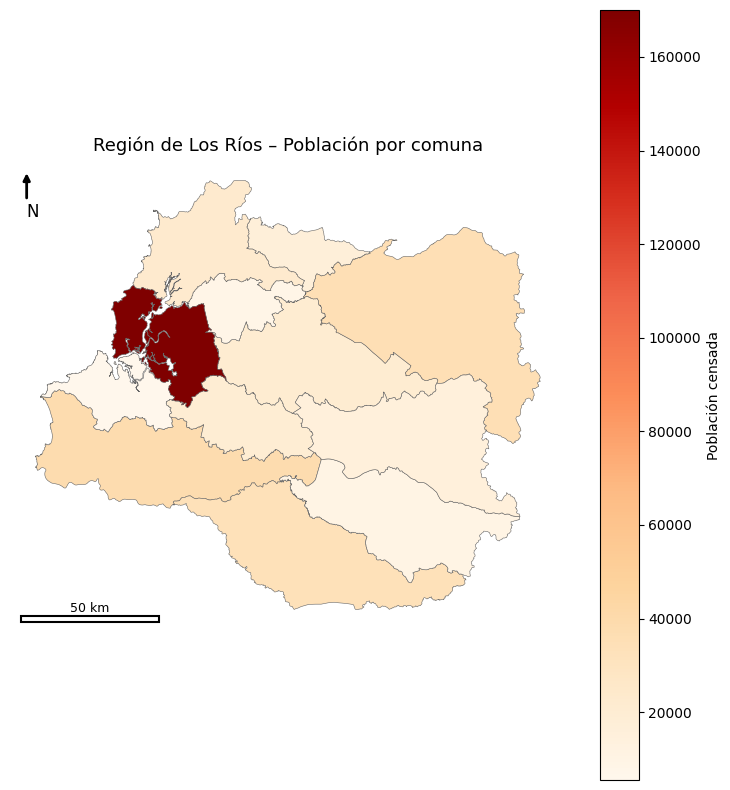

Mapa exportado en: Reports/figs/poblacion_region_de_los_rios.png


In [145]:
plot_region_choropleth(
    gdf_poblacion=gdf_poblacion,
    gdf_aeropuertos=gdf_aeropuertos,
    region_name="Región de Los Ríos"   
)

Parte 3 Puntos


In [146]:
gdf_los_rios = gdf_poblacion[gdf_poblacion['Region'] == "Región de Los Ríos"].copy()
region_geom = gdf_los_rios.geometry.union_all()

POIs en Los Ríos: 0


C:\Users\marcel gonzalez\AppData\Local\Temp\ipykernel_1016\607758000.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


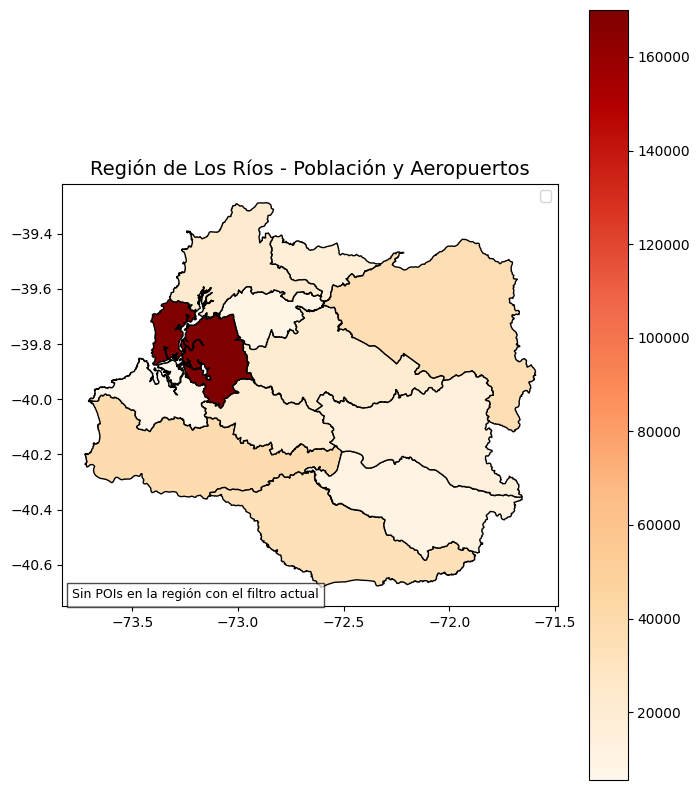

In [ ]:
gdf_los_rios = gdf_poblacion[gdf_poblacion['Region'] == "Región de Los Ríos"].copy()
gdf_aeropuertos = gdf_aeropuertos.to_crs(gdf_los_rios.crs)

gdf_aeropuertos_los_rios = gpd.clip(gdf_aeropuertos, gdf_los_rios)
print("POIs en Los Ríos:", len(gdf_aeropuertos_los_rios))
fig, ax = plt.subplots(figsize=(8, 10))

gdf_los_rios.plot(
    column="Población censada",
    cmap="OrRd",
    legend=True,
    edgecolor="black",
    ax=ax
)

if not gdf_aeropuertos_los_rios.empty:
    gdf_aeropuertos_los_rios.plot(
        ax=ax,
        color="blue",
        marker="^",
        markersize=80,
        label="Aeropuertos"
    )
else:
    ax.text(0.02, 0.02, "Sin POIs en la región con el filtro actual",
            transform=ax.transAxes, fontsize=9,
            bbox=dict(facecolor="white", alpha=0.7))

ax.set_title("Región de Los Ríos - Población y Aeropuertos", fontsize=14)
ax.legend()

# 4) Exporta al Reports 
os.makedirs("../Reports/figs", exist_ok=True)
plt.savefig("../Reports/figs/poblacion_pois.png", dpi=300, bbox_inches="tight")
plt.show()

In [148]:
aeropuertos_los_rios = gdf_aeropuertos[gdf_aeropuertos["Region"].str.contains("Región de Los Ríos", case=False, na=False)]

aeropuertos_los_rios

,objectid_1,cod_comuna,categoría,cod_oaci,cod_iata,Aerodromo,Region,Provincia,Comuna,geometry


### Parte 4: Zonal statistics de VIIRS por comuna

In [ ]:
#1) Estandarizacion de nombres

gdf_poblacion = gdf_poblacion.rename(columns={
    'brillo_promedio': 'viirs_mean',
    'brillo_total': 'viirs_sum',
    'Población censada': 'poblacion'
})

# 2) DataFrame final 
df_viirs = gdf_poblacion[['Region', 'Comuna', 'poblacion', 'viirs_mean', 'viirs_sum']].copy()

# 3)  Solo Región de Los Ríos
df_los_rios = df_viirs[df_viirs['Region'].str.contains('Ríos', case=False, na=False)].reset_index(drop=True)
df_los_rios.head()

,Region,Comuna,poblacion,viirs_mean,viirs_sum
0,Región de Los Ríos,La Unión,38907.0,0.186802,2422.637695
1,Región de Los Ríos,Los Lagos,21431.0,0.096089,1042.762329
2,Región de Los Ríos,Máfil,8074.0,0.171764,601.003540
3,Región de Los Ríos,Paillaco,19802.0,0.197045,1080.005737
4,Región de Los Ríos,Lanco,16876.0,0.276124,885.528503


In [150]:
with rasterio.open(ruta_raster) as src:
    print('CRS raster:', src.crs)
    print('Resolución:', src.res)
    print('NoData:', src.nodata)

CRS raster: EPSG:4326
Resolución: (0.0041666667, 0.0041666667)
NoData: None


In [ ]:
stats = zonal_stats(
    gdf_poblacion,
    ruta_raster,
    stats=['mean', 'sum'],
    nodata=0,            # ajust raster
    geojson_out=False
)
# Añade a la capa comunal
gdf_poblacion['viirs_mean'] = [s['mean'] for s in stats]
gdf_poblacion['viirs_sum']  = [s['sum']  for s in stats]

# 3) DataFrame con las columnas
gdf_poblacion = gdf_poblacion.rename(columns={'Población censada': 'poblacion'})
df_viirs = gdf_poblacion[['Region', 'Comuna', 'poblacion', 'viirs_mean', 'viirs_sum']].copy()

# Filtrar a Región de Los Ríos
df_los_rios = df_viirs[df_viirs['Region'].str.contains('Ríos', case=False, na=False)].reset_index(drop=True)
df_los_rios.head()

,Region,Comuna,poblacion,viirs_mean,viirs_sum
0,Región de Los Ríos,La Unión,38907.0,2.047876,2422.637695
1,Región de Los Ríos,Los Lagos,21431.0,1.479096,1042.762329
2,Región de Los Ríos,Máfil,8074.0,1.487633,601.003540
3,Región de Los Ríos,Paillaco,19802.0,1.341622,1080.005737
4,Región de Los Ríos,Lanco,16876.0,1.627810,885.528503


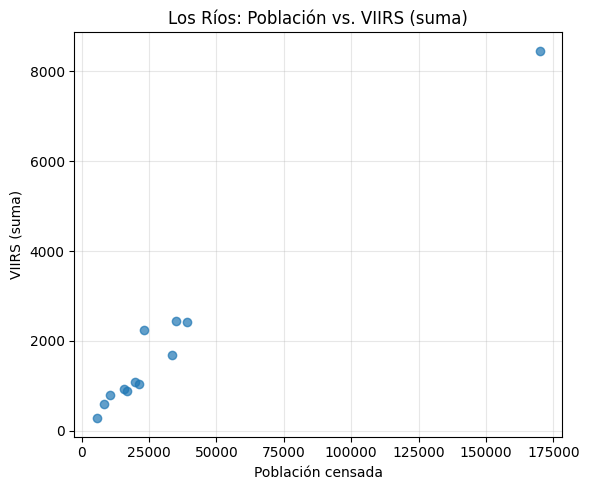

In [ ]:
# Carpetas de salida 
os.makedirs('../Reports/tables', exist_ok=True)
os.makedirs('../Reports/figs',   exist_ok=True)

# CSVs
df_viirs.to_csv('../Reports/tables/viirs_por_comuna.csv', index=False, encoding='utf-8')
df_los_rios.to_csv('../Reports/tables/viirs_por_comuna_los_rios.csv', index=False, encoding='utf-8')

# Scatter: población vs viirs_sum (para Los Ríos)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(df_los_rios['poblacion'], df_los_rios['viirs_sum'], alpha=0.7)
ax.set_xlabel('Población censada')
ax.set_ylabel('VIIRS (suma)')
ax.set_title('Los Ríos: Población vs. VIIRS (suma)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../Reports/figs/poblacion_vs_viirs_los_rios.png', dpi=300)
plt.show()

Parte 5 Analisis y visualizacion 

In [154]:
# Drop comunas sin datos
df_corr = gdf_poblacion[['poblacion', 'viirs_mean', 'viirs_sum']].dropna()

# Correlación Pearson
pearson_corr, pearson_p = pearsonr(df_corr['poblacion'], df_corr['viirs_sum'])

# Correlación Spearman
spearman_corr, spearman_p = spearmanr(df_corr['poblacion'], df_corr['viirs_sum'])

print(f"n = {len(df_corr)}")
print(f"Pearson: r = {pearson_corr:.3f}, p = {pearson_p:.3f}")
print(f"Spearman: ρ = {spearman_corr:.3f}, p = {spearman_p:.3f}")

n = 345
Pearson: r = 0.782, p = 0.000
Spearman: ρ = 0.804, p = 0.000


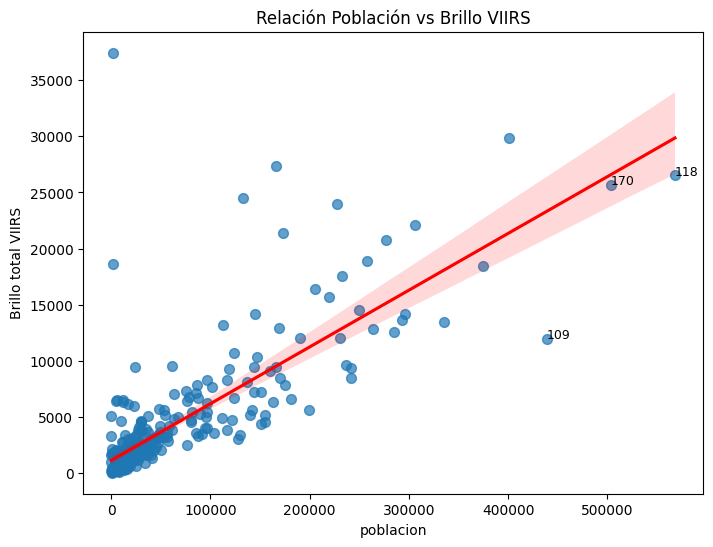

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

sns.regplot(
    data=df_corr,
    x='poblacion',
    y='viirs_sum',
    ax=ax,
    scatter_kws={'s':50, 'alpha':0.7},
    line_kws={'color':'red'}
)

# Detectar outliers simples: 
residuos = df_corr['viirs_sum'] - (df_corr['poblacion'] * pearson_corr)
outliers = df_corr.loc[residuos.abs().nlargest(3).index]

# Etiquetas
for idx, row in outliers.iterrows():
    ax.text(row['poblacion'], row['viirs_sum'], str(idx), fontsize=9)

ax.set_title("Relación Población vs Brillo VIIRS")
ax.set_xlabel("poblacion")
ax.set_ylabel("Brillo total VIIRS")
plt.show()

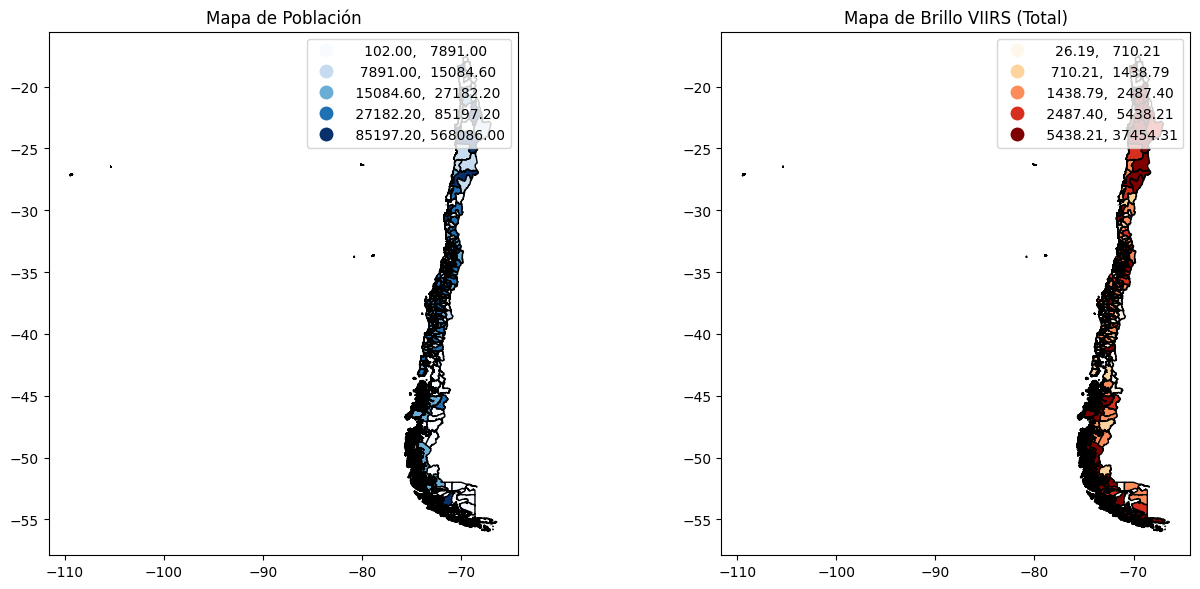

In [162]:
fig, axes = plt.subplots(1,2, figsize=(14,6))

# Mapa población
gdf_poblacion.plot(
    column='poblacion',
    cmap='Blues',
    scheme='Quantiles',
    k=5,
    edgecolor="black",
    legend=True,
    ax=axes[0]
)
axes[0].set_title("Mapa de Población")

# Mapa VIIRS (brillo total)
gdf_poblacion.plot(
    column='viirs_sum',
    cmap='OrRd',
    scheme='Quantiles',
    k=5,
    edgecolor="black",
    legend=True,
    ax=axes[1]
)
axes[1].set_title("Mapa de Brillo VIIRS (Total)")

plt.tight_layout()
plt.show()